In [1]:
!pip install sklearn catboost seaborn pyarrow

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import mlflow
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec
from mlflow.models.signature import infer_signature
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve, get_fpr_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mlflow.get_tracking_uri()

'https://ml-platform-3b36c8fb4e4070.ml.msk.vkcs.cloud'

In [4]:
#mlflow.set_tracking_uri("https://ml-platform-3b36c8fb4e4070.ml.msk.vkcs.cloud/")
mlflow.set_experiment(experiment_name="driver-accident")

<Experiment: artifact_location='mlflow-artifacts:/1', experiment_id='1', lifecycle_stage='active', name='driver-accident', tags={}>

### Данные

In [5]:
df = pd.read_parquet('driver-stat.parquet')

In [6]:
df.head()

,driver_id,age,sex,car_class,driving_experience,speeding_penalties,parking_penalties,total_car_accident,has_car_accident
0,ab3e7f31ace042fd89da60825c89ea6d,29,male,B,2,0,0,0,0
1,3be9de3ea320458889bc917524795aa0,25,female,B,1,2,0,0,0
2,4b520b87244c4e8db7f06d452c696786,24,female,D,2,1,0,0,0
3,643b83b2860349e280b9210683966b8e,22,male,B,1,2,0,0,0
4,ec08a7f8c2ce4940b4c6f639fb92ac8e,20,female,C,2,0,0,0,0


array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'driving_experience'}>],
       [<AxesSubplot: title={'center': 'speeding_penalties'}>,
        <AxesSubplot: title={'center': 'parking_penalties'}>],
       [<AxesSubplot: title={'center': 'total_car_accident'}>,
        <AxesSubplot: title={'center': 'has_car_accident'}>]],
      dtype=object)

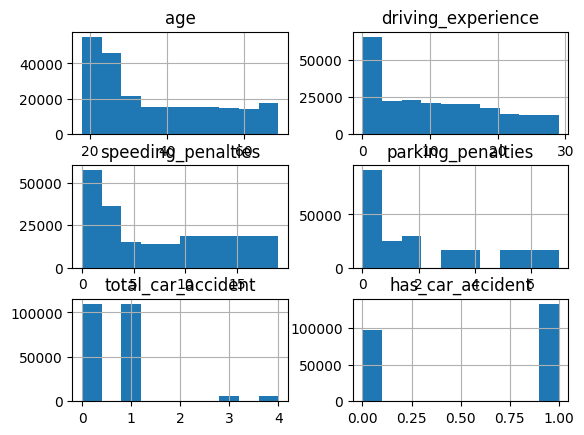

In [7]:
df.hist(bins=10)

In [8]:
mlflow.start_run()

<ActiveRun: >

In [9]:
FEATURES = ['age', 'sex', 'car_class', 'driving_experience', 'speeding_penalties', 'parking_penalties', 'total_car_accident']
CATEGORIAL_FEATURES = ['sex', 'car_class']
TARGET = 'has_car_accident'

In [10]:
mlflow.log_param('features', FEATURES)
mlflow.log_param('categorial features', CATEGORIAL_FEATURES)
mlflow.log_param('target', TARGET)

In [11]:
train_df = df[FEATURES]
targets = df[[TARGET]]

In [12]:
 X_train, X_test, y_train, y_test = train_test_split(train_df, targets, test_size=0.33, random_state=42)

In [13]:
train_pool = Pool(X_train, y_train, cat_features = CATEGORIAL_FEATURES, feature_names=FEATURES)
test_pool = Pool(X_test, cat_features = CATEGORIAL_FEATURES)

/home/jupyter-admin/.local/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


### Обучение, тюнинг и трекинг

In [14]:
model = CatBoostClassifier(iterations=10,
                           eval_metric='F1',
                           random_seed=17,
                           train_dir = "fit_track",
                           silent=False)

In [15]:
mlflow.log_param('model_type', model.__class__)
mlflow.set_tags(tags = {"engineering": "ML Platform",
                       "framework": "Catboost"})

In [16]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

In [17]:
mlflow.log_param('param_grid', grid)

In [18]:
grid_search_result = model.grid_search(grid, train_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9047689	test: 0.9038852	best: 0.9038852 (0)	total: 105ms	remaining: 944ms
1:	learn: 0.9047689	test: 0.9038852	best: 0.9038852 (0)	total: 148ms	remaining: 591ms
2:	learn: 0.9047689	test: 0.9038852	best: 0.9038852 (0)	total: 177ms	remaining: 414ms
3:	learn: 0.9047689	test: 0.9038852	best: 0.9038852 (0)	total: 217ms	remaining: 326ms
4:	learn: 0.9047689	test: 0.9038852	best: 0.9038852 (0)	total: 257ms	remaining: 257ms
5:	learn: 0.9047689	test: 0.9038852	best: 0.9038852 (0)	total: 293ms	remaining: 195ms
6:	learn: 0.9047689	test: 0.9038852	best: 0.9038852 (0)	total: 321ms	remaining: 138ms
7:	learn: 0.9047689	test: 0.9038852	best: 0.9038852 (0)	total: 360ms	remaining: 89.9ms
8:	learn: 0.9047689	test: 0.9038852	best: 0.9038852 (0)	total: 395ms	remaining: 43.9ms
9:	learn: 0.9047689	test: 0.9038852	best: 0.9038852 (0)	total: 430ms	remaining: 0us

bestTest = 0.9038852496
bestIteration = 0

0:	loss: 0.9038852	best: 0.9038852 (0)	total: 517ms	remaining: 15s
0:	learn: 0.9047689	test: 0.9

In [19]:
mlflow.log_param('best_params', grid_search_result['params'])

In [20]:
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = model.predict(X_test)

roc_auc = roc_auc_score(y_test, y_test_pred_proba)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

mlflow.log_metric('roc_auc', roc_auc)
mlflow.log_metric('precision', precision)
mlflow.log_metric('recall', recall)
mlflow.log_metric('f1', f1)

print(f'ROC AUC: {roc_auc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

ROC AUC: 0.9027537535789404
Precision: 0.9080745341614906
Recall: 0.9132726075006247
F1: 0.9106661532537544


In [21]:
input_schema = Schema([
  ColSpec("double", "age"),
  ColSpec("string", "sex"),
  ColSpec("string", "car_class"),
  ColSpec("double", "driving_experience"),
  ColSpec("double", "speeding_penalties"),
  ColSpec("double", "parking_penalties"),
  ColSpec("double", "total_car_accident")
])
output_schema = Schema([ColSpec("long", "has_car_accident")])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

In [22]:
mlflow.catboost.log_model(model,
                          artifact_path="driver-accident",
                          registered_model_name="driver-accident",
                          signature=signature)

Registered model 'driver-accident' already exists. Creating a new version of this model...
2022/11/03 17:33:04 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: driver-accident, version 13
Created version '13' of model 'driver-accident'.


ModelInfo(artifact_path='driver-accident', flavors={'python_function': {'loader_module': 'mlflow.catboost', 'python_version': '3.9.7', 'data': 'model.cb', 'env': 'conda.yaml'}, 'catboost': {'catboost_version': '1.1', 'code': None, 'model_type': 'CatBoostClassifier', 'save_format': 'cbm', 'data': 'model.cb'}}, model_uri='runs:/b2d316def79c47fa99ad921312298b6a/driver-accident', model_uuid='3d8cd85de24c42be9cd3334bc9693e54', run_id='b2d316def79c47fa99ad921312298b6a', saved_input_example_info=None, signature_dict={'inputs': '[{"name": "age", "type": "double"}, {"name": "sex", "type": "string"}, {"name": "car_class", "type": "string"}, {"name": "driving_experience", "type": "double"}, {"name": "speeding_penalties", "type": "double"}, {"name": "parking_penalties", "type": "double"}, {"name": "total_car_accident", "type": "double"}]', 'outputs': '[{"name": "has_car_accident", "type": "long"}]'}, utc_time_created='2022-11-03 17:33:01.754135', mlflow_version='1.26.1.dev0')

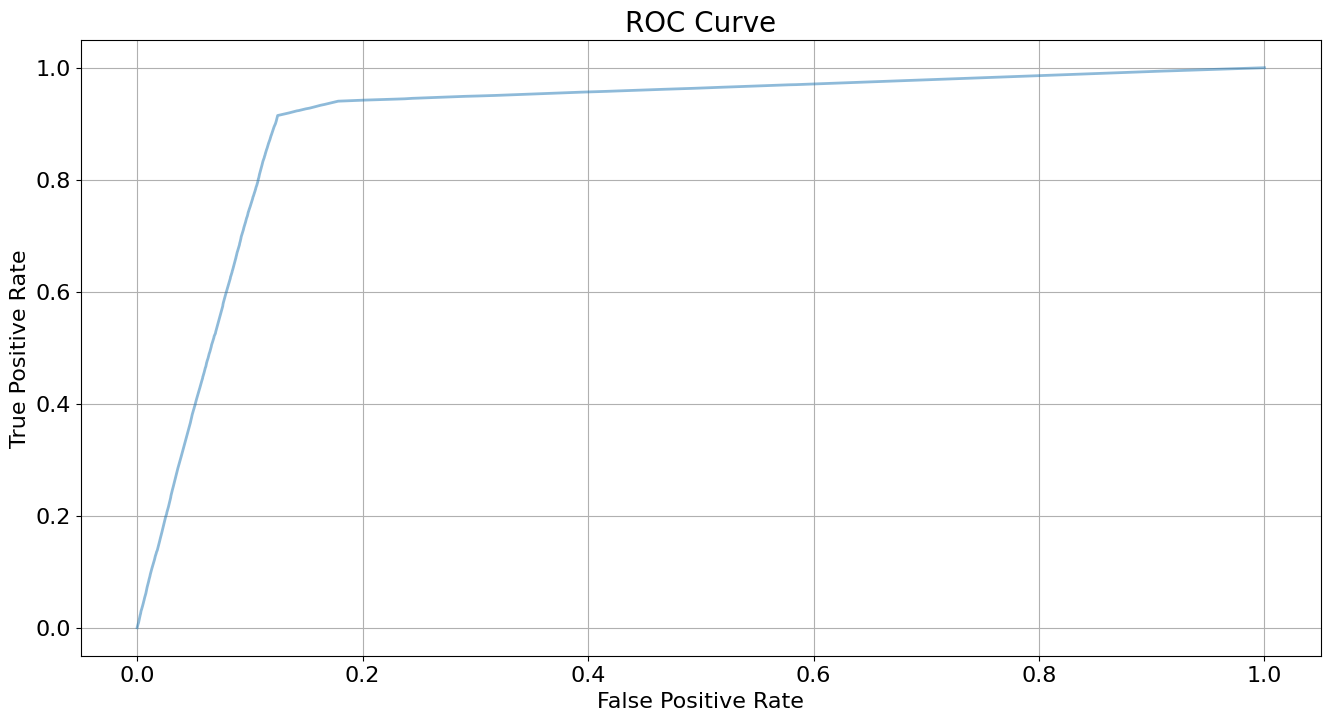

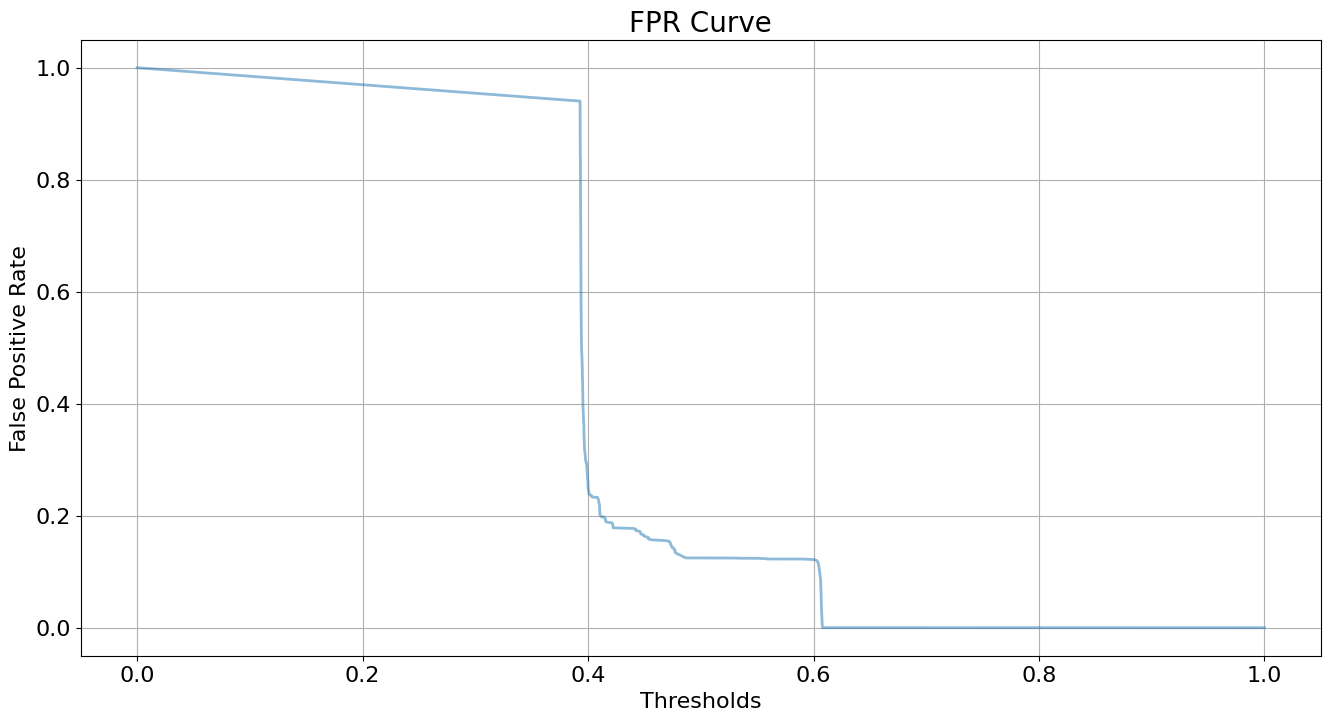

In [23]:
roc_curve_values = get_roc_curve(model, train_pool, plot=True)
(thresholds, fpr) = get_fpr_curve(curve=roc_curve_values, plot=True)

In [24]:
mlflow.log_artifact("DriverAccident.ipynb")

In [25]:
mlflow.end_run()

In [26]:
#!python train-job.py